# Face Swap

In this script, I superimpose a mesh I generated from a single image onto the Tron video.

In [1]:
import numpy as np
import cv2
import visvis as vv

#### Transform matrix to align two vectors.

In [7]:
def align_matrix(a, b):
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)
    vx = np.array([[0, -v[2], v[1]],
         [v[2], 0, -v[0]],
         [-v[1], v[0], 0]])
    i = np.identity(3)
    r = i + vx + (vx ** 2) * (1 - c) / s ** 2
    return r

#### Apply the rotation matrix to a list of vertices.

In [ ]:
def rotate(result, a_v, b_v):
    a_v = a_v / np.linalg.norm(a_v)
    b_v = b_v / np.linalg.norm(b_v)
    r = align_matrix(a_v, b_v)
    result = np.dot(result, r.T)
    return result

#### Generate a vector by averaging facial keypoints.
I use this vector to align the mesh to the video.

In [304]:
def face_vector(keypoints):
    nose = keypoints[30]
    els = keypoints[np.arange(len(keypoints)) != 30]
    els = els - nose
    v1 = np.mean(els, axis=0)
    
    te = keypoints[8]
    els = keypoints[np.arange(len(keypoints)) != 8]
    els = els - te
    v2 = np.mean(els, axis=0)
    v2 = np.cross(v1, v2)
    v2 = np.cross(v1, v2)
    
    return chin, v1, nose, v2

#### Load the keypoints for the image and video and then get the vectors.

In [344]:
joey_kp = np.load("joey_keypoints.npy")
scale = 525.0 / 639
joey_kp = joey_kp * scale
joey_chin, joey_v1, joey_nose, joey_v2 = face_vector(joey_kp)

In [314]:
tron_kps = np.load("keypoints_preds_smooth.npy")
tron_chins, 
tron_v1s, 
tron_noses, 
tron_v2s = zip(*[face_vector(kp) for kp in tron_kps])

#### Scale the mesh to match the Tron keypoints.

In [222]:
def get_face_scale(keypoints_a, keypoints_b):
    b_ear2ear = keypoints_b[16] - keypoints_b[0]
    a_ear2ear = keypoints_a[16] - keypoints_a[0]

    face_scale = .9 * np.linalg.norm(b_ear2ear) / np.linalg.norm(a_ear2ear)
    return face_scale

face_scale = get_face_scale(joey_kp, tron_kps[0])

In [8]:
def screenshot(mesh, 
               img, 
               output_file_name, 
               blue=True, 
               texture=None, 
               texture_values=None):
    verts, faces, normals, values = mesh
        
    vv.clf()
    
    im = None
    if img is not None:
        im = img
        t = vv.imshow(im)
        t.interpolate = True
    
    values = None
    if blue:
        values = np.array([[.5, .5, 1] for z, y, x in verts])
    elif texture_values is not None:
        values = texture_values
    else:
        w = float(im.shape[1])
        h = float(im.shape[0])
        values = [[x / w, y / h] for x, y, z in verts]
        texture = im

    vvmesh = vv.mesh(verts, 
                     faces=faces, 
                     normals=normals, 
                     values=values, 
                     texture=texture)

    a = vv.gca()
    a.camera.fov = 0 # orthographic
    a.camera.azimuth = 0
    a.camera.elevation = 90
    a.camera.roll = 0
    a.light0.ambient = 0.2 # 0.2 is default for light 0
    a.light0.diffuse = 1.0 # 1.0 is default

    if output_file_name is not None:
        vv.screenshot(output_file_name, vv.gcf(), sf=2, bg='w')
    else:
        vv.use().Run()

In [11]:
def load_img(file_name):
    img = cv2.imread(file_name)
    if "tron" in file_name:
        img = img[115:640, 763:1287, :]
    return img

#### Load the mesh and texture
Scale the mesh to match the Tron keypoints. Adjust the mesh z-coordinates to match keypoints.

In [301]:
mesh = (verts, faces, normals, values) = np.load('joey_mesh.npy')
texture = load_img("joey.jpg")
b,g,r = cv2.split(texture)
texture = cv2.merge([r,g,b])
texture = cv2.flip(texture, 1)
texture_values = [(x / 192, y / 192) for x, y, z in verts]

verts[:,2] = verts[:,2] / 2.0
verts[:,0] = 192 - verts[:,0]
scale = 525.0 / 192
verts[:] *= scale
verts[:] -= joey_nose
verts[:] *= face_scale
verts[:] += joey_nose

mesh_nose = np.sort(verts[:,2])[-1]
verts[:, 2] += joey_nose[2] - mesh_nose

#### Align mesh vertices to Tron keypoints

In [311]:
def align_verts(verts, 
                normals, 
                a_chin, b_chin, 
                a_v1, b_v1, 
                a_nose, b_nose, 
                a_v2, b_v2):
    result = verts
    an = normals
    
    result = result - a_nose
    result = rotate(result, a_v1, b_v1)
    an = rotate(normals, a_v1, b_v1)
    result = result + b_nose
    
    return result, an

#### Generage edges connecting keypoints
These will be used to generate triangles that cover the mesh

In [16]:
edges = []
chin = np.arange(4, 12)
edges += zip(chin[:-1], chin[1:])

lower_lip = np.arange(54, 60)[::-1]
lower_lip = np.insert(lower_lip, 0, 48)
edges += zip(lower_lip[:-1], lower_lip[1:])

edges += zip(chin[:-1], lower_lip)
edges += zip(chin[1:], lower_lip)
edges += [(11, 12), (12, 54)]

upper_lip = np.arange(48, 55)
edges += zip(upper_lip[:-1], upper_lip[1:])

bottom_upper_lip = np.arange(60, 65)
edges += zip(bottom_upper_lip[:-1], bottom_upper_lip[1:])

top_lower_lip = np.arange(64, 68)
top_lower_lip = np.append(top_lower_lip, 60)[::-1]
edges += zip(top_lower_lip[:-1], top_lower_lip[1:])

edges += zip(upper_lip[:3], bottom_upper_lip[:3])
edges += zip(upper_lip[1:4], bottom_upper_lip[:3])

edges += zip(upper_lip[4:], bottom_upper_lip[2:])
edges += zip(upper_lip[4:-1], bottom_upper_lip[3:])

edges += zip(bottom_upper_lip[1:-1], top_lower_lip[1:-1])
edges += zip(bottom_upper_lip[1:-2], top_lower_lip[2:-1])

edges += zip(lower_lip[:3], top_lower_lip[:3])
edges += zip(lower_lip[1:4], top_lower_lip[:3])

edges += zip(lower_lip[4:], top_lower_lip[2:])
edges += zip(lower_lip[4:-1], top_lower_lip[3:])

nose_bottom = np.arange(31, 36)
edges += zip(nose_bottom[:-1], nose_bottom[1:])

edges += zip(nose_bottom, upper_lip[:-2])
edges += zip(nose_bottom, upper_lip[1:-1])
edges += [(nose_bottom[-1], upper_lip[-1])]

left_eyebrow = np.arange(22, 27)
edges += zip(left_eyebrow[:-1], left_eyebrow[1:])

right_eyebrow = np.arange(17, 22)
edges += zip(right_eyebrow[:-1], right_eyebrow[1:])

left_eye_top = np.arange(42, 46)
edges += zip(left_eye_top[:-1], left_eye_top[1:])

right_eye_top = np.arange(36, 40)
edges += zip(right_eye_top[:-1], right_eye_top[1:])

edges += zip(left_eyebrow[:-1], left_eye_top)
edges += zip(left_eyebrow[1:], left_eye_top)

edges += zip(right_eyebrow[:-1], right_eye_top)
edges += zip(right_eyebrow[1:], right_eye_top)

nose = [30] * 5
edges += zip(nose, nose_bottom)

nose = np.arange(27, 31)
edges += zip(nose[:-1], nose[1:])

left_eye_bottom = [42, 47, 46, 45]
edges += zip(left_eye_bottom[:-1], left_eye_bottom[1:])

right_eye_bottom = [36, 41, 40, 39]
edges += zip(right_eye_bottom[:-1], right_eye_bottom[1:])

left_eye = [44, 46, 43, 47]
edges += zip(left_eye[:-1], left_eye[1:])

right_eye = [38, 40, 37, 41]
edges += zip(right_eye[:-1], right_eye[1:])

p = [27, 42, 28, 47]
edges += zip(p[:-1], p[1:])

p = [27, 39, 28, 40]
edges += zip(p[:-1], p[1:])

p = [22, 27, 21, 22]
edges += zip(p[:-1], p[1:])

p = [35, 29, 31, 28, 35]
edges += zip(p[:-1], p[1:])

face_left = np.arange(12, 17)
edges += zip(face_left[:-1], face_left[1:])

face_right = np.arange(0, 5)
edges += zip(face_right[:-1], face_right[1:])

p = [12, 35, 47, 13, 35]
edges += zip(p[:-1], p[1:])

p = [4, 31, 40, 3, 31]
edges += zip(p[:-1], p[1:])

p = [13, 46, 14, 45, 15, 26, 16]
edges += zip(p[:-1], p[1:])

p = [3, 41, 2, 36, 1, 17, 0]
edges += zip(p[:-1], p[1:])

[(138.16741444418034, 156.85986394964991), (-386.6018222785861, -425.66604220231602)]


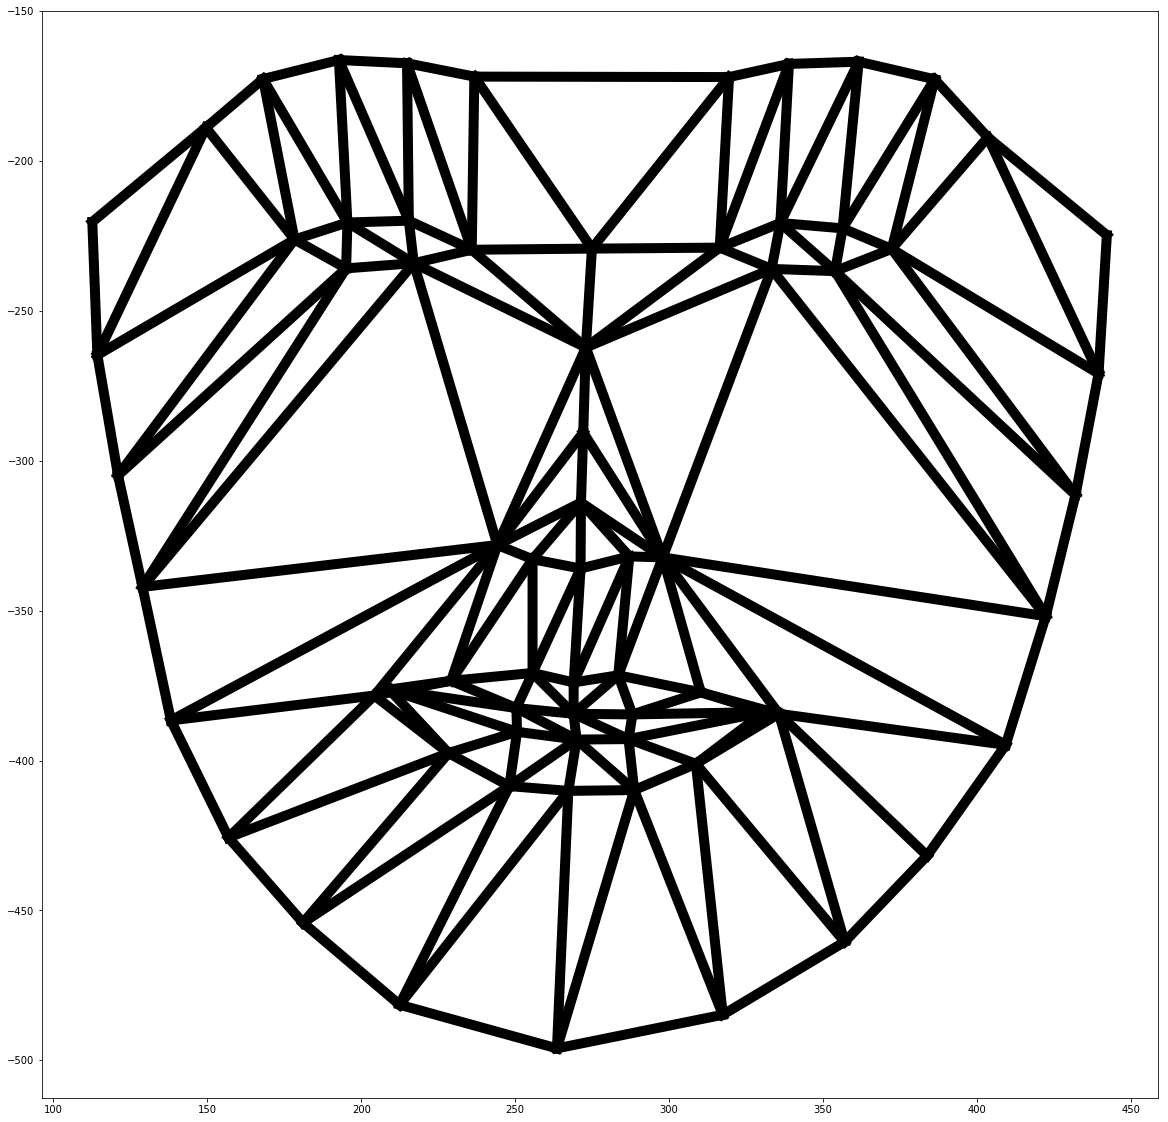

In [361]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20,20]

kp = np.copy(joey_kp[:,:-1])
kp[:,1] = 0 - kp[:,1]
# plt.scatter(*zip(*kp))

print(zip(*(kp[list(edges[0])])))

for edge in edges:
    plt.plot(*zip(*(kp[list(edge)])), linestyle='-', color='black', lw=10)
    
plt.show()

#### Get triangles from edges

In [17]:
def get_triangles(edges):
    edges_dict = {}
    triangles = []
    for edge in edges:
        a, b = edge
        a_edges = []
        if a in edges_dict:
            a_edges = edges_dict[a]
        b_edges = []
        if b in edges_dict:
            b_edges = edges_dict[b]
        gen = (shared for shared in a_edges if shared in b_edges)
        for shared in gen:
            triangles.append((a, b, shared))
        edges_dict[a] = a_edges + [b]
        edges_dict[b] = b_edges + [a]
    return triangles

In [18]:
def get_triangle_points(triangles, keypoints):
    triangles = np.array(triangles)
    l = len(triangles)
    triangle_points = keypoints[triangles.flat]
    triangle_points = np.reshape(triangle_points, (l, 3, 3))
    return triangle_points

#### Find the mesh vertices covered by each triangle

In [19]:
def verts_in_triangle(triangle, verts):
    triangle = triangle[:,:-1]
    a, b, c = triangle
    verts = verts[:,:-1]
    verts = np.expand_dims(verts, axis=1)
    
    n = verts.shape[0]
    
    t1 = np.tile((a, b), (n, 1, 1))
    t1 = np.concatenate((t1, verts), axis=1)
    
    t2 = np.tile((a, c), (n, 1, 1))
    t2 = np.concatenate((t2, verts), axis=1)
    
    t3 = np.tile((b, c), (n, 1, 1))
    t3 = np.concatenate((t3, verts), axis=1)
    
    t = np.array(triangle)
    t = t[1:] - t[0]
    t_a = np.abs(np.linalg.det(t)) / 2
    
    def area(tn):
        z = tn[:,0]
        tn = tn[:,1:]
        tn[:,0] -= z
        tn[:,1] -= z
        return np.abs(np.linalg.det(tn)) / 2
    
    a = np.sum(np.array([area(tn) for tn in (t1, t2, t3)]), axis=0)
    inside = np.isclose(a, t_a)
    
    return np.arange(len(verts))[inside]

#### Center the two sets of keypoints onto each other
In preperation for morphing the mesh.

In [307]:
joey_kp_cent = joey_kp - joey_nose
joey_kp_cent *= face_scale

def center_keypoints(keypoints, chin, v1_a, v1_b, nose, v2_a, v2_b):
    result = keypoints
    result = result - nose
    result = rotate(result, v1_a, v1_b)
    return result

tron_kps_cent = [center_keypoints(kp, chin, v1_a, joey_v1, nose, v2_a, joey_v2) 
                 for kp, chin, v1_a, nose, v2_a 
                 in zip(tron_kps, tron_chins, tron_v1s, tron_noses, tron_v2s)]

In [294]:
verts_cent = verts - joey_nose
triangles = get_triangles(edges)
joey_triangle_points = get_triangle_points(triangles, joey_kp_cent)
verts_per_triangle = [verts_in_triangle(triangle, verts_cent) 
                      for triangle in joey_triangle_points]

#### Transfrom vertices from one triangle to the other

In [140]:
def transform_triangle(a, b, verts):
    t = cv2.getAffineTransform(np.float32(a[:,:-1]), np.float32(b[:,:-1]))
    verts2d = np.copy(verts)
    verts2d[:,2] = 1
    result = np.copy(verts)
    result[:,:-1] = np.dot(verts2d, t.T)
    return result

In [298]:
def morph_mesh(a_triangle_points, 
               b_triangle_points, 
               verts_per_triangle, 
               verts_cent):
    result = np.copy(verts_cent)
    for a, b, vpt in zip(a_triangle_points, 
                         b_triangle_points, 
                         verts_per_triangle):
        if sum(vpt) > 0:
            result[vpt] = transform_triangle(a, b, verts_cent[vpt])
    return result

In [308]:
morphed_verts = []
for tron_kp_cent in tron_kps_cent:
    a_triangle_points = joey_triangle_points
    b_triangle_points = get_triangle_points(triangles, tron_kp_cent)
    morphed_verts.append(morph_mesh(a_triangle_points, 
                                    b_triangle_points, 
                                    verts_per_triangle, 
                                    verts_cent))
    
morphed_verts = np.add(morphed_verts, joey_nose)

#### Use Tron keypoints to align the transformed mesh with the video

In [312]:
for i in range(1, 101):
    av, an = align_verts(morphed_verts[i-1], normals,
                     joey_chin, 
                     tron_chins[i-1], 
                     joey_v1, 
                     tron_v1s[i-1], 
                     joey_nose, 
                     tron_noses[i-1], 
                     joey_v2, 
                     tron_v2s[i-1])
    img = load_img("/Users/paul/Downloads/tron_frames/frame{:04d}.jpg".format(i))
    screenshot((av, faces, an, values), 
               img, 
               "face_swap/frame{:04d}.jpg".format(i), 
               blue=False, 
               texture=texture, 
               texture_values=texture_values)

In [5]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/3imw-U0ewHE" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')